In [10]:
import pennylane as qml
from pennylane import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 

## Dataset

In [16]:
# number of blocks
rows = 100

# defining pixel values with a block which is likely to be an edge block
#e.g. tensor([[113,  22, 194, 228]], requires_grad=True)
pix_vals = np.random.randint(0, 256, size=(1, 4)) 

for i in range(rows//2):
    
    # 4 random digits between 0 to 255 with differences of at most 15
    # e.g. rand_num=66 => choices between 51 to 66 => tensor([[56, 58, 65, 63]], requires_grad=True)
    rand_num = np.random.randint(15, 256)
    smooth = np.random.randint(rand_num-15, rand_num, size=(1, 4))
    
    # adding smooth blocks to pix_vals
    pix_vals = np.vstack((pix_vals, smooth))

for i in range(rows//2-1):
    
    edge = np.random.randint(0, 256, size=(1, 4))
    
    # adding edge blocks to pix_vals
    pix_vals = np.vstack((pix_vals, edge))
    

# calculate differences of pixel values of the first pixels and other three pixels
# e.g. difference1 = tensor([[ 35],
                            # [  2],
                            # [  5],
                            # [  1], ...
difference1 = np.abs(pix_vals[:,0] - pix_vals[:,1]).reshape(-1, 1)
difference2 = np.abs(pix_vals[:,0] - pix_vals[:,2]).reshape(-1, 1)
difference3 = np.abs(pix_vals[:,0] - pix_vals[:,3]).reshape(-1, 1)

# e.g. differences = tensor([[ 35,  72,  71],
                            # [  2,   1,   2],
                            # [  5,   5,   1],
                            # [  1,  10,  10], ...
differences = np.concatenate((difference1, difference2, difference3), axis=1)


diff_binary = differences <= 15
# e.g. tensor([[False, False, False],
             # [ True,  True,  True],
            # [ True,  True,  True],
             # [ True,  True,  True], ...
            

# each row of target is true if the corresponding row of diff_binary includes three true's
target = np.all(diff_binary, axis=1).reshape(-1, 1)

target2 = ~target

target = target.astype(np.int8)

target2 = target2.astype(np.int8)

# target = target * 2 - 1 # shift label from {0, 1} to {-1, 1}


# shuffling data including pixel values and their targets
data = np.array(pix_vals, requires_grad=False)
data = np.hstack((data, np.array(target, requires_grad=False)))

np.random.shuffle(data)

X = data[:, :4]
Y = data[:, 4]

## Quantum

In [12]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="autograd")

def circuit(weights, x):
    
    qml.AmplitudeEmbedding(features=x, wires=range(2), normalize=True)

    qml.StronglyEntanglingLayers(weights=weights, wires=range(2))

    return qml.expval(qml.PauliZ(0))


shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=2)
weights = np.random.randn(shape[0], shape[1], shape[2])
print(circuit(weights, X[0]))
print(qml.draw(circuit, expansion_strategy="device")(weights, X[0]))


-0.309858278915635
0: ─╭QubitStateVector(M0)──Rot(-1.22,0.53,-0.21)─╭●─╭X─┤  <Z>
1: ─╰QubitStateVector(M0)──Rot(0.59,0.37,0.31)───╰X─╰●─┤     
M0 = 
[0.48815667+0.j 0.49672082+0.j 0.50528498+0.j 0.50956705+0.j]


In [13]:
def mae(labels, predictions):
    return np.mean(np.abs(predictions - Y))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def cost(weights, bias, x, y):
    predictions = variational_classifier(weights, bias, X)
    return mae(Y, predictions)
    
def accuracy(labels, predictions, error=0.3):
    true_num = np.sum(np.abs(predictions - labels) <= error)
    return true_num.item()/len(labels)


epoch: 1 | Cost: 1.0206998511250955 | Accuracy: 0.365
epoch: 2 | Cost: 0.980002770220987 | Accuracy: 0.696
epoch: 3 | Cost: 0.9283289257731409 | Accuracy: 0.543
epoch: 4 | Cost: 0.8924729383456251 | Accuracy: 0.517
epoch: 5 | Cost: 0.8911811267220676 | Accuracy: 0.522
epoch: 6 | Cost: 0.9048204731220105 | Accuracy: 0.536
epoch: 7 | Cost: 0.9058586357727202 | Accuracy: 0.537
epoch: 8 | Cost: 0.8905128067579329 | Accuracy: 0.532
epoch: 9 | Cost: 0.8751021618989501 | Accuracy: 0.519
epoch: 10 | Cost: 0.8754298799698327 | Accuracy: 0.511
epoch: 11 | Cost: 0.8884915441212025 | Accuracy: 0.506
epoch: 12 | Cost: 0.9002468795993359 | Accuracy: 0.504
epoch: 13 | Cost: 0.9013875184039073 | Accuracy: 0.507
epoch: 14 | Cost: 0.8913986488563391 | Accuracy: 0.508
epoch: 15 | Cost: 0.876887965825639 | Accuracy: 0.505
epoch: 16 | Cost: 0.8673568930735658 | Accuracy: 0.505
epoch: 17 | Cost: 0.8672391630433255 | Accuracy: 0.507
epoch: 18 | Cost: 0.8719005581983668 | Accuracy: 0.509
epoch: 19 | Cost: 0.8

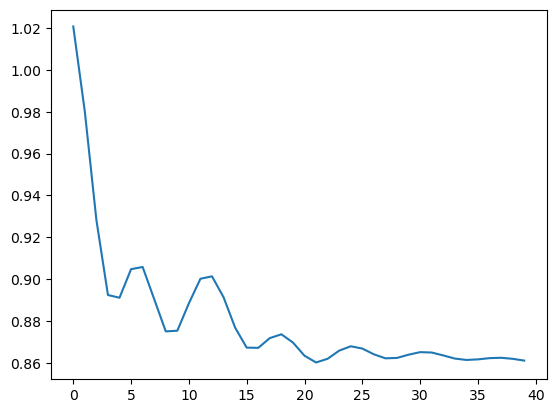

In [15]:
epochs = 40

# opt = qml.GradientDescentOptimizer(.4)
opt = qml.MomentumOptimizer(stepsize=0.8, momentum=0.9)


shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.randn(shape[0], shape[1], shape[2])

bias = np.zeros(1)

batch_size = 5 

cost_graph = []

for epoch in range(epochs):
    # update the circuit parameters
    # weights, bias, _ , _ = opt.step(cost, weights, bias, X, Y)
    
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, _, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)
        
    epoch_cost= cost(weights, bias, X, Y)
    cost_graph.append(epoch_cost)
    
    # Compute accuracy
    predictions = np.sign(variational_classifier(weights, bias, X))
    acc = accuracy(Y, predictions, error=0.3)
    
    print("epoch:", epoch + 1, "| Cost:", epoch_cost, "| Accuracy:", acc)

plt.plot(range(epochs), cost_graph)

In [8]:
data

tensor([[ 94, 133, 185, 114,   0],
        [135, 143, 140, 136,   1],
        [218, 184, 117, 247,   0],
        ...,
        [108, 100, 106, 100,   1],
        [242, 235, 233, 229,   1],
        [143, 151, 150, 144,   1]], requires_grad=False)

In [9]:
print(circuit(weights, X))

[ 0.91784784  0.98543912  0.98857887  0.97615656  0.5407064   0.7456104
  0.98067992  0.97811982  0.97647326  0.90604491  0.34071406  0.79627448
  0.64343939  0.99081054  0.98369598  0.98253785  0.98697699  0.41625931
  0.98286866  0.98417388  0.97668358  0.98510388  0.69180857  0.49744198
  0.405074    0.98004678  0.79857659 -0.05302842  0.26602069  0.71696449
  0.84009173  0.40759865  0.53422828  0.62916638  0.98448918  0.92334223
  0.97743222  0.9487373   0.82198     0.55673424  0.93377063  0.45746669
  0.89703347  0.6380461   0.98522796  0.95239319  0.95312394  0.98348551
  0.17310447  0.81944898  0.95006128  0.98378338  0.97678128  0.83175482
  0.59026659  0.58422754  0.97948543  0.97624299  0.86111961  0.79835499
  0.38632362  0.98958125  0.70811691  0.45418648  0.98721989  0.5733663
  0.81457384  0.55653805  0.98856697  0.968791    0.98157224  0.78388709
  0.14967826  0.45188312  0.57503716  0.91335381  0.73968321  0.84785029
  0.5524586   0.61587547  0.97935274  0.82768306  0.9